## Adpated from Luecken pre-processing from Github

https://github.com/theislab/single-cell-tutorial

In [1]:
# Folder holding data, also used for output
data_loc = '/Users/pk/Data/'

#### Load packages

In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.9 numpy==1.14.5 scipy==1.3.0 pandas==0.23.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

#### Load data

In [4]:
#Data files
sample_strings = ['Duo_M1', 'Duo_M2', 'Jej_M1', 'Jej_M2', 'Il_M1', 'Il_M2']
sample_id_strings = ['3', '4', '5', '6', '7', '8']
file_base = data_loc + 'GSE92332_RAW/GSM283657'
exp_string = '_Regional_'
data_file_end = '_matrix.mtx'
barcode_file_end = '_barcodes.tsv'
gene_file_end = '_genes.tsv'
cc_genes_file = '../Macosko_cell_cycle_genes.txt'

In [5]:
# First data set load & annotation
#Parse Filenames
sample = sample_strings.pop(0)
sample_id = sample_id_strings.pop(0)
data_file = file_base+sample_id+exp_string+sample+data_file_end
barcode_file = file_base+sample_id+exp_string+sample+barcode_file_end
gene_file = file_base+sample_id+exp_string+sample+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['sample'] = [sample]*adata.n_obs
adata.obs['region'] = [sample.split("_")[0]]*adata.n_obs
adata.obs['donor'] = [sample.split("_")[1]]*adata.n_obs

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes

... reading from cache file cache/Users-pk-Data-GSE92332_RAW-GSM2836573_Regional_Duo_M1_matrix.h5ad


In [6]:
# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i]
    sample_id = sample_id_strings[i]
    data_file = file_base+sample_id+exp_string+sample+data_file_end
    barcode_file = file_base+sample_id+exp_string+sample+barcode_file_end
    gene_file = file_base+sample_id+exp_string+sample+gene_file_end
    
    #Load data
    adata_tmp = sc.read(data_file, cache=True)
    adata_tmp = adata_tmp.transpose()
    adata_tmp.X = adata_tmp.X.toarray()

    barcodes_tmp = pd.read_csv(barcode_file, header=None, sep='\t')
    genes_tmp = pd.read_csv(gene_file, header=None, sep='\t')
    
    #Annotate data
    barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
    barcodes_tmp.set_index('barcode', inplace=True)
    adata_tmp.obs = barcodes_tmp
    adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs
    adata_tmp.obs['region'] = [sample.split("_")[0]]*adata_tmp.n_obs
    adata_tmp.obs['donor'] = [sample.split("_")[1]]*adata_tmp.n_obs
    
    genes_tmp.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes_tmp.set_index('gene_symbol', inplace=True)
    adata_tmp.var = genes_tmp
    adata_tmp.var_names_make_unique()

    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample_id')
    adata.obs.drop(columns=['sample_id'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')
    
del adata_tmp

... reading from cache file cache/Users-pk-Data-GSE92332_RAW-GSM2836574_Regional_Duo_M2_matrix.h5ad


Making variable names unique for controlled concatenation.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/Users-pk-Data-GSE92332_RAW-GSM2836575_Regional_Jej_M1_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/Users-pk-Data-GSE92332_RAW-GSM2836576_Regional_Jej_M2_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/Users-pk-Data-GSE92332_RAW-GSM2836577_Regional_Il_M1_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/Users-pk-Data-GSE92332_RAW-GSM2836578_Regional_Il_M2_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [7]:
#Assign variable names and gene id columns
adata.var_names = [g.split("_")[1] for g in adata.var_names]
adata.var['gene_id'] = [g.split("_")[1] for g in adata.var['gene_id']]

In [8]:
# Annotate the data sets
print(adata.obs['region'].value_counts())
print('')
print(adata.obs['donor'].value_counts())
print('')
print(adata.obs['sample'].value_counts())

Duo    4554
Jej    4496
Il     4303
Name: region, dtype: int64

M2    6711
M1    6642
Name: donor, dtype: int64

Jej_M2    2668
Il_M1     2466
Duo_M1    2348
Duo_M2    2206
Il_M2     1837
Jej_M1    1828
Name: sample, dtype: int64


In [9]:
# Checking the total size of the data set
adata.shape # should be (13353, 27998)

(13353, 27998)

In [10]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

... storing 'donor' as categorical
... storing 'region' as categorical
... storing 'sample' as categorical


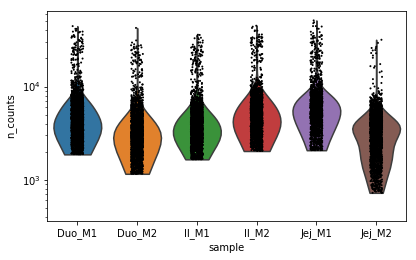

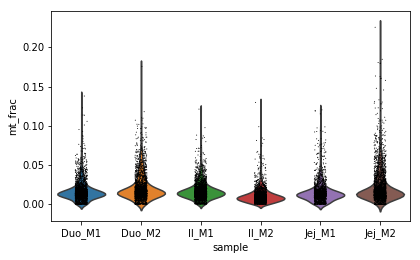

In [11]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='sample', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample')

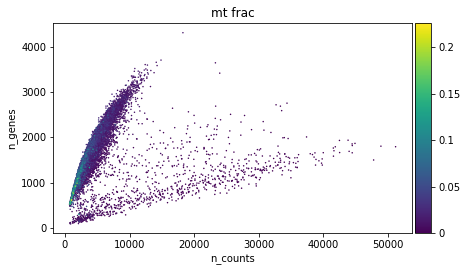

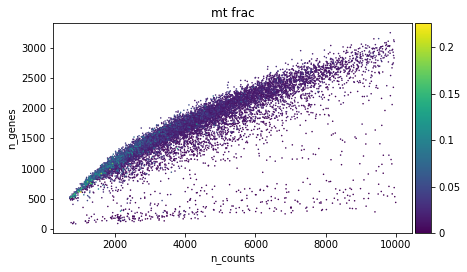

In [12]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

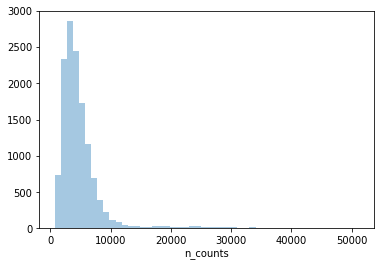

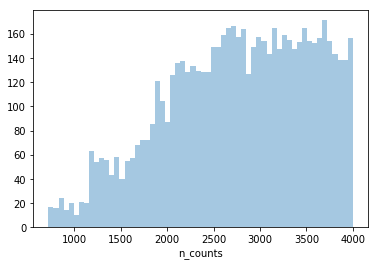

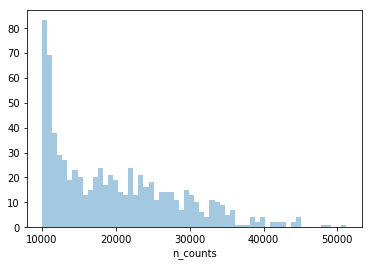

In [13]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()

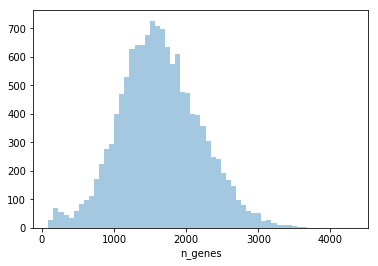

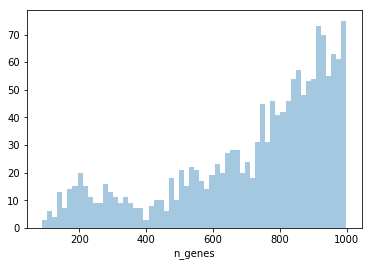

In [14]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

In [15]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 13353
filtered out 479 cells that haveless than 1500 counts
Number of cells after min count filter: 12874
filtered out 16 cells that havemore than 40000 counts
Number of cells after max count filter: 12858
Number of cells after MT filter: 12858
filtered out 401 cells that haveless than 700 genes expressed


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 12457


In [16]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
filtered out 15180 genes that are detectedin less than 20 cells
Number of genes after cell filter: 12818


In [21]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)

# perform Louvain cluster, larger resolution increases number of cluster, decreases cluster size
sc.tl.louvain(adata_pp, key_added='louvain_r1')
sc.tl.louvain(adata_pp, resolution=0.5, key_added='louvain_r05', random_state=10)


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 15


/Users/pk/Library/Python/3.7/lib/python/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../usr/local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain_r05', the cluster labels (adata.obs, categorical) (0:00:02)


In [22]:
# Save lists of Louvain cluster labels
with open(data_loc + 'louvain_r05_labels_Luecken.pickle', 'wb') as handle:
    pickle.dump(adata_pp.obs.louvain_r05.tolist()[:2000], handle)
    
with open(data_loc + 'louvain_r1_labels_Luecken.pickle', 'wb') as handle:
    pickle.dump(adata_pp.obs.louvain_r1.tolist()[:2000], handle)

In [24]:
input_groups = adata_pp.obs['louvain_r05']
data_mat = adata.X.T

In [25]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [26]:
#Delete adata_pp to save RAM
del adata_pp

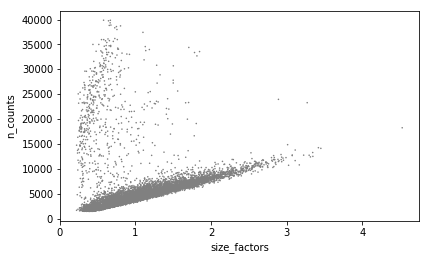

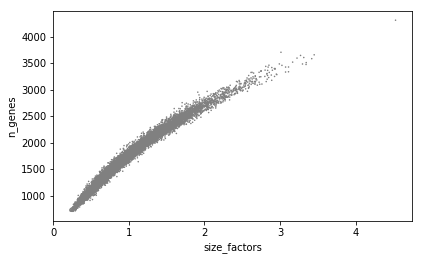

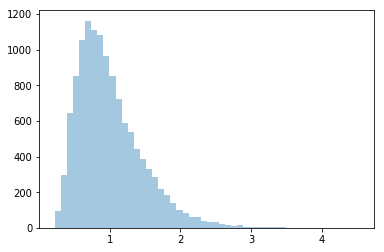

In [27]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [28]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [29]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [30]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

In [31]:
# ComBat batch correction
sc.pp.combat(adata, key='sample')

Standardizing Data across genes.

Found 6 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



/usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:269: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_it_sol" failed type inference due to: Cannot unify array(float64, 2d, C) and array(float64, 1d, C) for 'sum2', defined at /usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (311)

File "../../../../../usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py", line 311:
def _it_sol(s_data, g_hat, d_hat, g_bar, t2, a, b, conv=0.0001) -> Tuple[float, float]:
    <source elided>
        g_new = (t2*n*g_hat + d_old*g_bar) / (t2*n + d_old)
        sum2 = s_data - g_new.reshape((g_new.shape[0], 1)) @ np.ones((1, s_data.shape[1]))
        ^

[1] During: typing of assignment at /usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (313)

File "../../../../../usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py", line 313:
def _it_sol(s_data, g_hat, d_hat

Adjusting data



#### Save processed data file

In [32]:
adata.write(data_loc + 'adata_Luecken_compressed.h5ad', compression='gzip')